In [93]:


from utils.utils import setup_project_root, plot_eta
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
from scipy import stats

ImportError: cannot import name 'plot_eta' from 'utils' (C:\Users\zak\Projects\PycharmProjects\data-science\utils.py)

In [96]:
from typing import Iterable, Tuple, Optional

# -------- Helper function (must be defined first) -------- #

def pd_isna(x):
    """Small helper to avoid pandas hard dependency in eta_squared."""
    try:
        import pandas as _pd
        return _pd.isna(x)
    except Exception:
        # fallback: use numpy
        return np.asarray(x) != np.asarray(x)


# -------- Effect size: Eta squared (categorical -> numerical) -------- #

def eta_squared(categories: Iterable, values: Iterable) -> float:
    """Compute eta squared (η²) for a categorical predictor and numerical outcome.

    η² = SS_between / (SS_between + SS_within)

    Args:
        categories: Iterable of category labels (array-like)
        values: Iterable of numeric values (array-like)

    Returns:
        float: eta squared in [0, 1]
    """
    categories = np.asarray(list(categories))
    values = np.asarray(list(values), dtype=float)

    # Drop rows with missing either category or value
    mask = (~pd_isna(categories)) & (~np.isnan(values))
    categories = categories[mask]
    values = values[mask]

    if categories.size == 0:
        raise ValueError("No valid observations after removing missing values.")

    overall_mean = np.mean(values)

    ss_within = 0.0
    ss_between = 0.0

    for cat in np.unique(categories):
        subgroup = values[categories == cat]
        if subgroup.size == 0:
            continue
        subgroup_mean = np.mean(subgroup)
        ss_within += np.sum((subgroup - subgroup_mean) ** 2)
        ss_between += subgroup.size * (subgroup_mean - overall_mean) ** 2

    denom = ss_within + ss_between
    if denom == 0:
        return 0.0
    return float(ss_between / denom)


def eta_label(eta2: float) -> str:
    """Qualitative label for eta squared using common thresholds.

    Thresholds (Cohen-like): Small < 0.06, Medium < 0.14, else Large.
    """
    if eta2 < 0.06:
        return "Small"
    if eta2 < 0.14:
        return "Medium"
    return "Large"


def plot_eta(categories: Iterable,
             values: Iterable,
             title: Optional[str] = None,
             ax=None,
             show: bool = True,
             kind: str = "box") -> Tuple[str, float, object]:
    """Visualize eta squared with a per-category distribution plot and annotation.

    Draws a box/violin plot of the numeric variable across categories, overlays the
    overall mean, and annotates the plot with η² and its qualitative label.

    Args:
        categories: Categorical variable (array-like)
        values: Numerical variable (array-like)
        title: Optional title for the plot
        ax: Optional matplotlib Axes to draw on
        show: If True, calls plt.show() at the end
        kind: 'box' or 'violin'

    Returns:
        (label, eta2, ax): qualitative label, eta squared value, and the Axes used.
    """
    import seaborn as sns  # local import to avoid hard dependency outside plotting contexts
    import matplotlib.pyplot as plt

    import pandas as pd

    data = pd.DataFrame({"category": categories, "value": values})
    data = data.dropna(subset=["category", "value"])  # basic NA handling

    if data.empty:
        raise ValueError("No data to plot after dropping NA values.")

    eta2 = eta_squared(data["category"], data["value"])
    label = eta_label(eta2)

    if ax is None:
        _, ax = plt.subplots(figsize=(8, 5))

    if kind == "violin":
        sns.violinplot(data=data, x="category", y="value", inner=None, ax=ax, color="#93c5fd")
        sns.boxplot(data=data, x="category", y="value", ax=ax, whis=1.5, width=0.2, showcaps=True,
                    boxprops=dict(alpha=0.6))
    else:
        sns.boxplot(data=data, x="category", y="value", ax=ax)
        sns.stripplot(data=data, x="category", y="value", ax=ax, color="#666", alpha=0.5, size=3, jitter=0.2)

    # Overall mean line
    overall_mean = data["value"].mean()
    ax.axhline(overall_mean, color="red", linestyle="--", linewidth=1, label=f"Overall mean = {overall_mean:.2f}")

    # Annotation for eta squared
    ax.text(0.99, 0.98, f"η² = {eta2:.3f} ({label})", transform=ax.transAxes,
            ha="right", va="top", fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#333", alpha=0.9))

    ax.set_xlabel("Category")
    ax.set_ylabel("Value")
    if title is None:
        title = "Effect size (η²) across categories"
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(axis="y", alpha=0.2)

    if show:
        plt.tight_layout()
        plt.show()

    return label, eta2, ax


In [97]:
setup_project_root()

WindowsPath('C:/Users/zak/Projects/PycharmProjects/data-science')

In [98]:
df = pd.read_csv(r"data/synthetic_dataset.csv")
planes = pd.read_csv(r"data/planes.csv")
df

,Category,Price,Rating,Stock,Discount
0,NaN,5548.0,1.870322,NaN,0.0
1,NaN,3045.0,4.757798,NaN,38.0
2,NaN,4004.0,NaN,In Stock,0.0
3,NaN,4808.0,1.492085,NaN,33.0
4,NaN,1817.0,NaN,Out of Stock,23.0
...,...,...,...,...,...
4357,NaN,4436.0,4.728335,NaN,49.0
4358,B,6236.0,NaN,Out of Stock,4.0
4359,NaN,3283.0,NaN,Out of Stock,9.0
4360,D,2999.0,4.425995,NaN,40.0


In [99]:
df.info()

for cols in df.columns:
    print(df[cols].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4362 entries, 0 to 4361
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  1614 non-null   object 
 1   Price     4188 non-null   float64
 2   Rating    2312 non-null   float64
 3   Stock     3010 non-null   object 
 4   Discount  3970 non-null   float64
dtypes: float64(3), object(2)
memory usage: 170.5+ KB
Category
C    0.263321
D    0.252788
A    0.249690
B    0.234201
Name: proportion, dtype: float64
Price
1493.0    0.000955
4887.0    0.000955
1558.0    0.000955
3182.0    0.000955
3282.0    0.000955
            ...   
2555.0    0.000239
5355.0    0.000239
324.0     0.000239
7813.0    0.000239
4494.0    0.000239
Name: proportion, Length: 3422, dtype: float64
Rating
1.870322    0.000433
4.757798    0.000433
1.492085    0.000433
3.668341    0.000433
4.983998    0.000433
              ...   
2.410736    0.000433
1.433035    0.000433
4.728335    0.000433
4.425995   

## Step 1: Missing Data

- How bad is it?
- What can I do with it?

<Axes: >

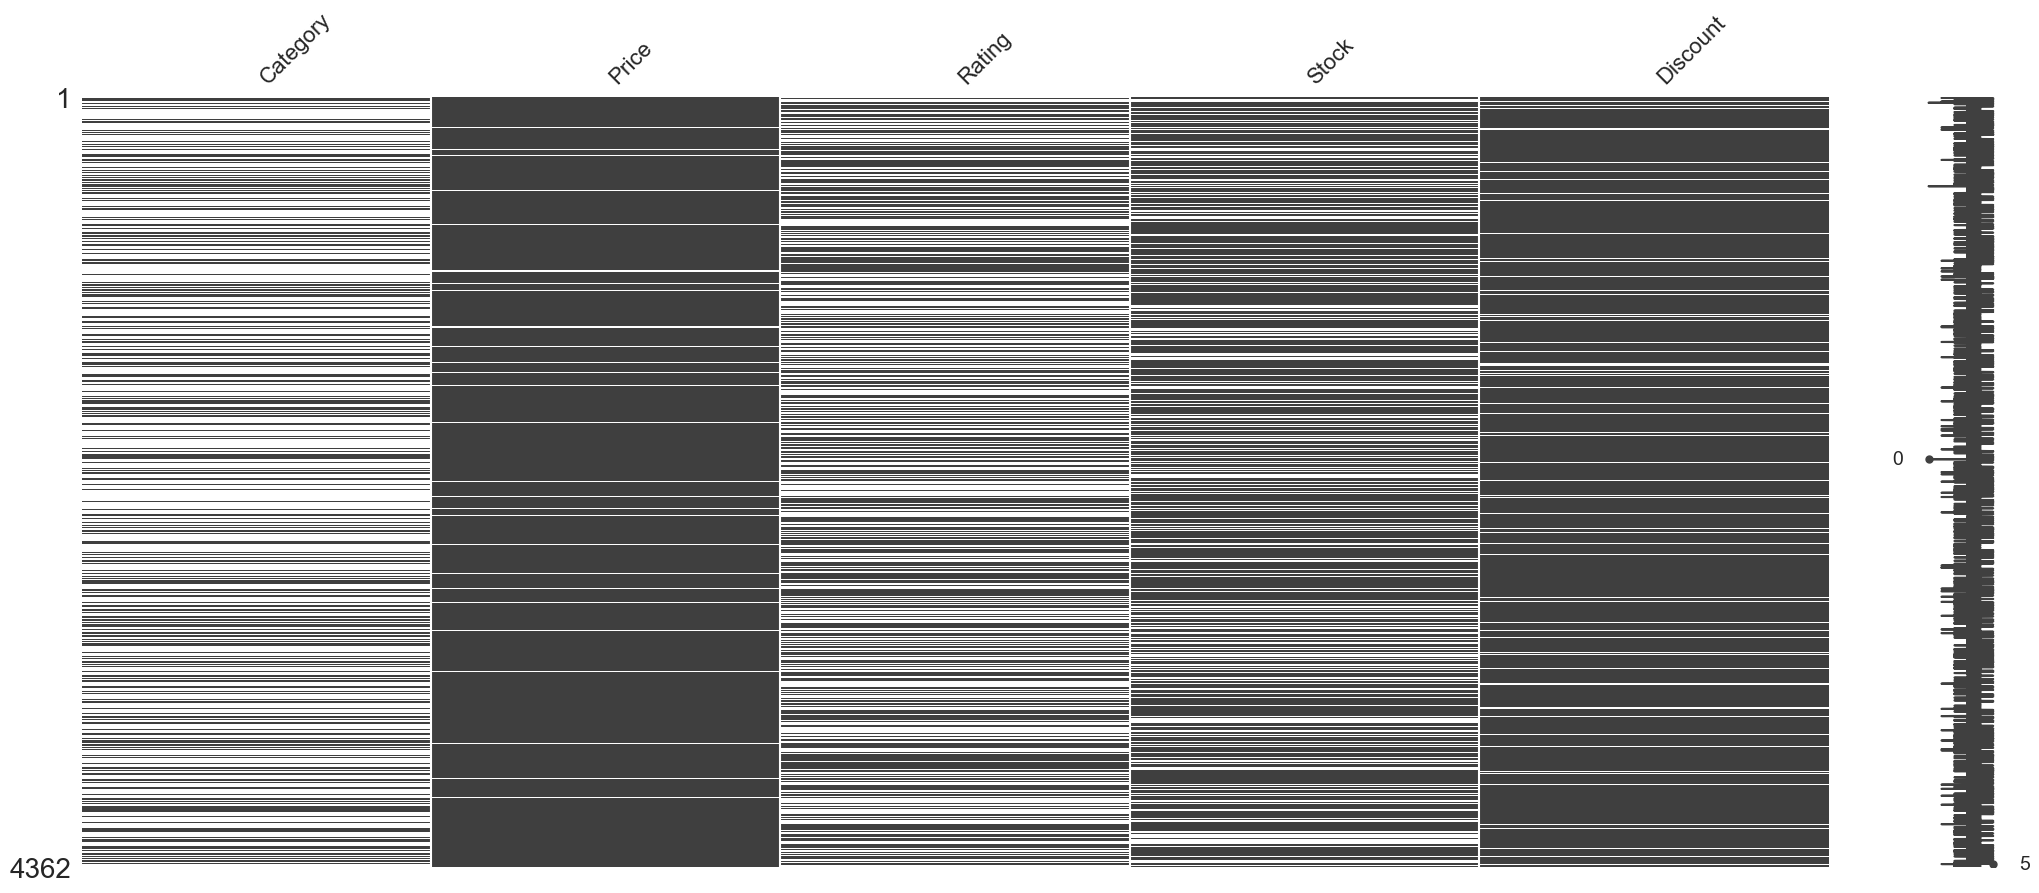

In [100]:
msno.matrix(df)

In [101]:
category_df = df.loc[df['Category'].notna()]

<Axes: >

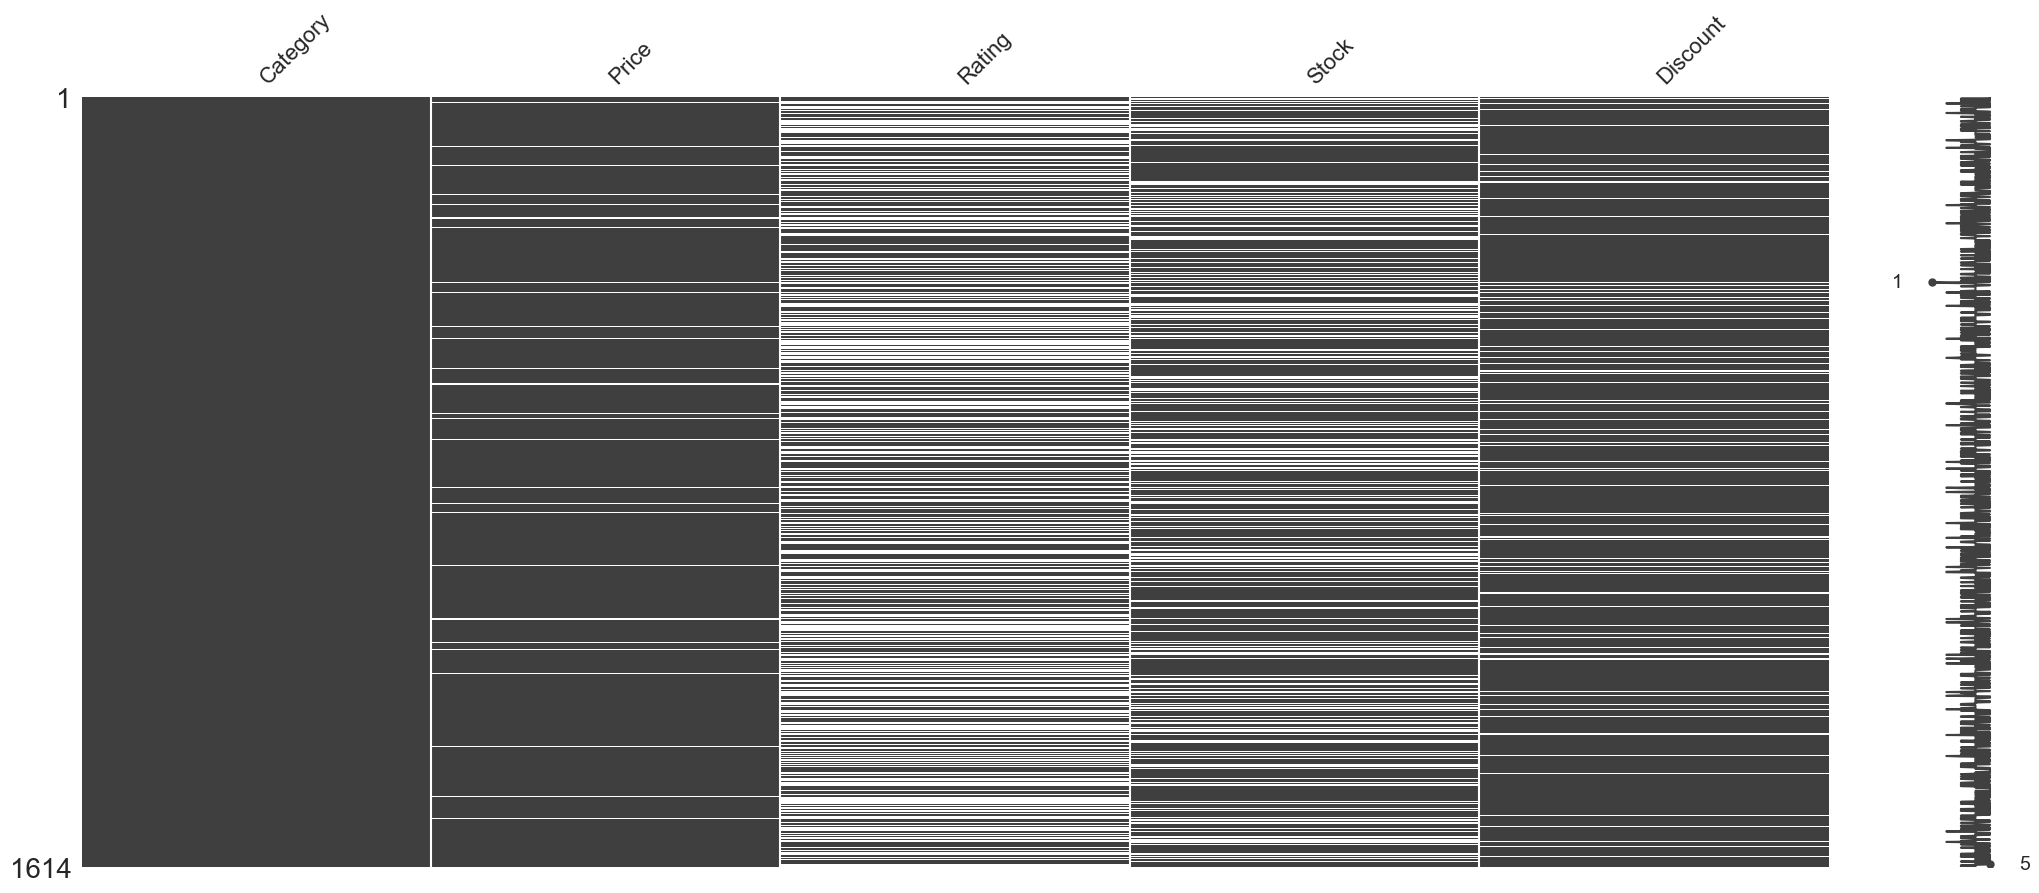

In [102]:
msno.matrix(category_df)

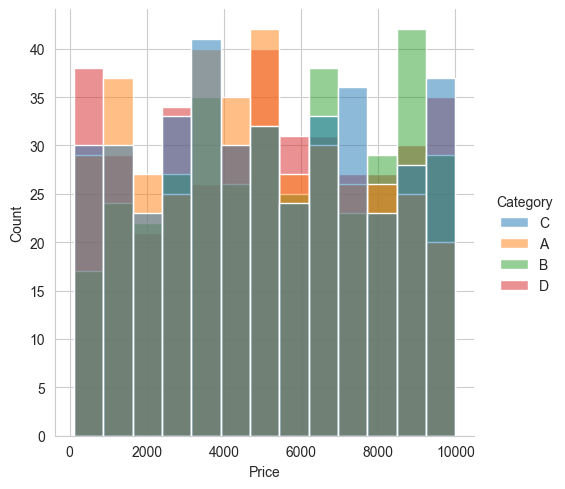

In [103]:
sns.displot(category_df, x='Price', hue='Category')

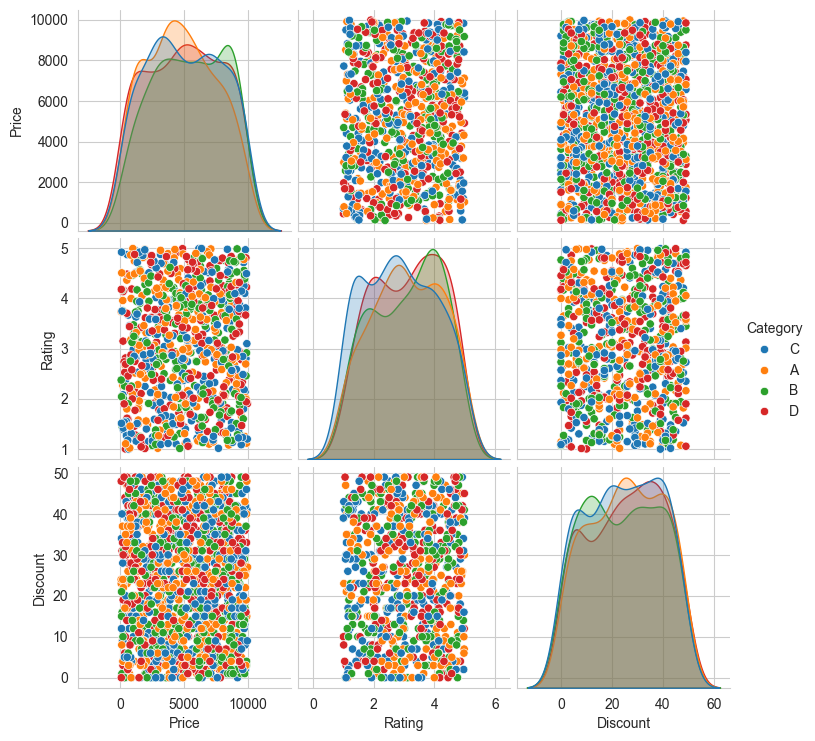

In [104]:
sns.pairplot(data=category_df, hue="Category")

## Thoughts on pairplot.

Can see the ranges of the fields.
- price 0 to 10000
- rating 1 to 5
- discount 0 to 50

Category seems fairly even distributed between those ranges

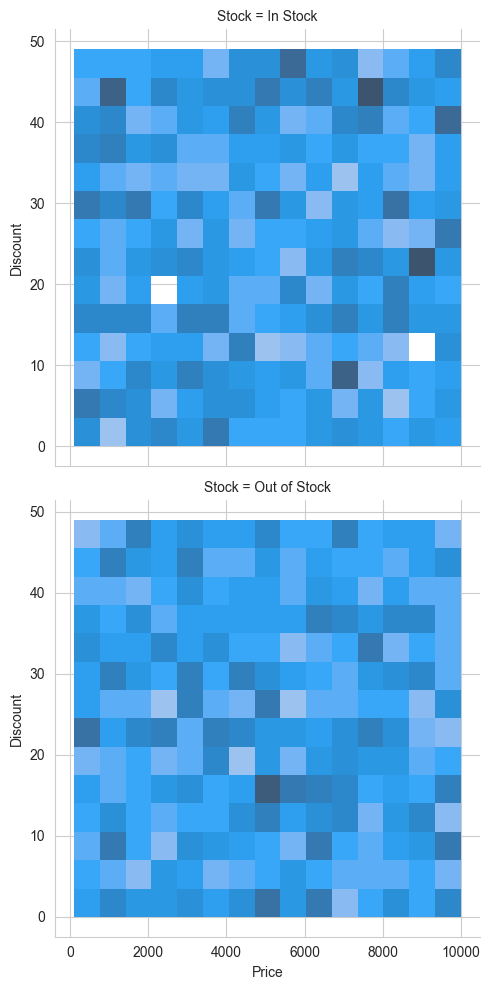

In [105]:
sns.displot(df, x='Price', y='Discount', row='Stock')
# looks like static

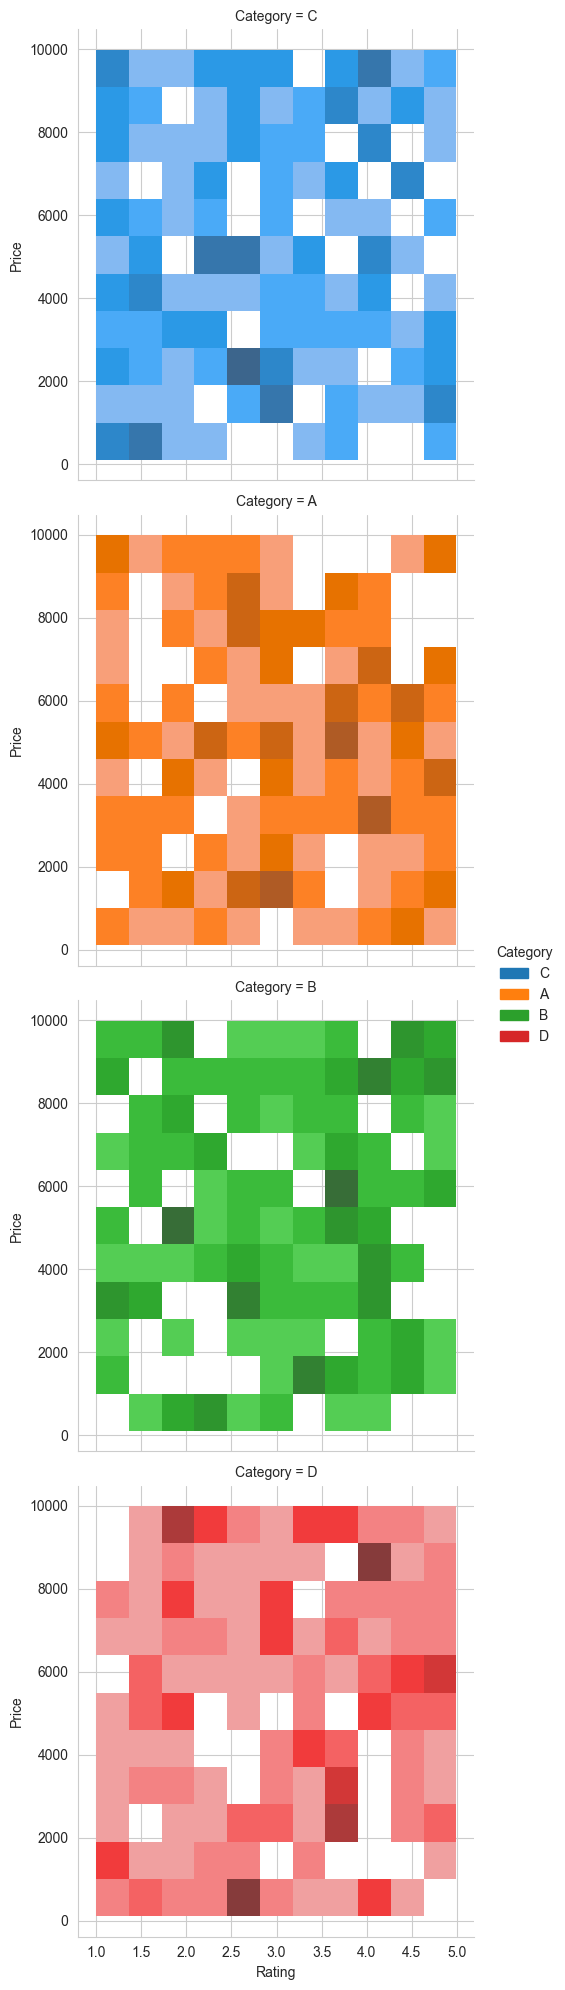

In [106]:
sns.displot(df, x='Rating', y='Price', row='Category', hue='Category')

<Axes: xlabel='Category', ylabel='Price'>

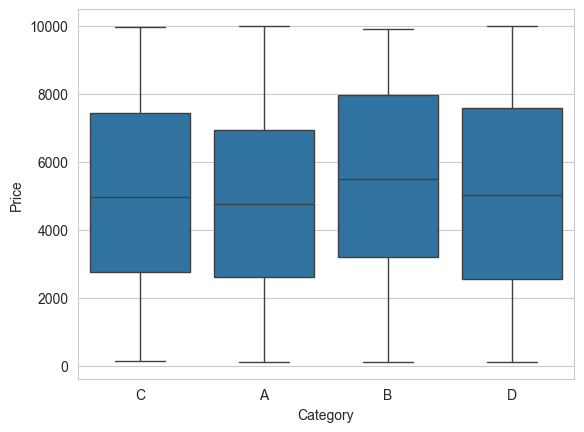

In [107]:
sns.boxplot(category_df, x='Category', y='Price')

## Effect Size

1. Effect Size of price to rating. Numerical to numerical.
2. Effect Size of category to price. Categorical to numerical.


In [108]:
# Pearson R
price_and_rating = df[['Price', 'Rating']].dropna()
stats.pearsonr(price_and_rating.Price, price_and_rating.Rating)
# PearsonRResult(statistic=np.float64(0.021099291710370366), pvalue=np.float64(0.3198320577130192))
# Basically no correlation and even the correlation I do have isn't statistically significant.

PearsonRResult(statistic=np.float64(0.021099291710370366), pvalue=np.float64(0.3198320577130192))

In [109]:
df.Stock.value_counts()
df.Category.value_counts()

Category
C    425
D    408
A    403
B    378
Name: count, dtype: int64

In [110]:
# Create contingency table from two categorical columns
category_and_stock = pd.crosstab(df['Category'], df['Stock'])

# Perform chi-square test
chi2, p, dof, expected = stats.chi2_contingency(category_and_stock)

# Calculate Cramer's V for effect size
n = np.sum(category_and_stock.values)
min_dimension = min(category_and_stock.shape[0]-1, category_and_stock.shape[1]-1)
cramer_v = np.sqrt(chi2 / n / min_dimension)

print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"Cramer's V: {cramer_v:.4f}")

Chi-square statistic: 2.5788
P-value: 0.4612
Degrees of freedom: 3
Cramer's V: 0.0479


## ETA Coefficient

- Effect of a categorical variable on a numerical variable

In [111]:
non_null_planes = planes.dropna()

In [112]:
def eta_coef(categories, values):
    # change inputs to numpy arrays
    categories = np.array(categories)
    values = np.array(values)

    # Create bins
    effect_sizes = [0.06, 0.14]

    # label for the eddect
    effect_labels = ['Small', 'Medium', 'Large']

    ss_e = 0
    ss_g = 0
    for category in set(categories):
        subgroup = values[np.where(categories == category)[0]]
        # print(f"Subgroup: {subgroup}")
        ss_e += np.sum((subgroup - np.mean(subgroup))**2)
        ss_g += len(subgroup) * ((np.mean(subgroup) - np.mean(values))**2)

    effect_size = effect_labels[int(np.digitize([(ss_g/(ss_e + ss_g))], effect_sizes, right=False) [0])]

    return effect_size, (ss_g/(ss_e + ss_g))

eta_coef(categories=non_null_planes['Duration'], values=non_null_planes['Price'])

('Large', np.float64(0.5429271130747537))

In [113]:
def eta_coef(categories, values):
    """
    Calculate eta squared coefficient (η²) to measure effect size between categorical and numerical variables.
    
    Args:
        categories: Categorical variable (array-like)
        values: Numerical variable (array-like)
    
    Returns:
        tuple: (effect_label, eta_squared_value)
    """
    categories = np.array(categories)
    values = np.array(values)
    
    overall_mean = np.mean(values)
    
    # Calculate sum of squares
    ss_within = 0  # Within-group variance
    ss_between = 0  # Between-group variance
    
    for category in set(categories):
        subgroup = values[categories == category]
        subgroup_mean = np.mean(subgroup)
        
        ss_within += np.sum((subgroup - subgroup_mean) ** 2)
        ss_between += len(subgroup) * ((subgroup_mean - overall_mean) ** 2)
    
    eta_squared = ss_between / (ss_within + ss_between)
    
    # Classify effect size
    if eta_squared < 0.06:
        effect_label = 'Small'
    elif eta_squared < 0.14:
        effect_label = 'Medium'
    else:
        effect_label = 'Large'
    
    return effect_label, eta_squared


eta_coef(categories=non_null_planes['Duration'], values=non_null_planes['Price'])

('Large', np.float64(0.5429271130747537))

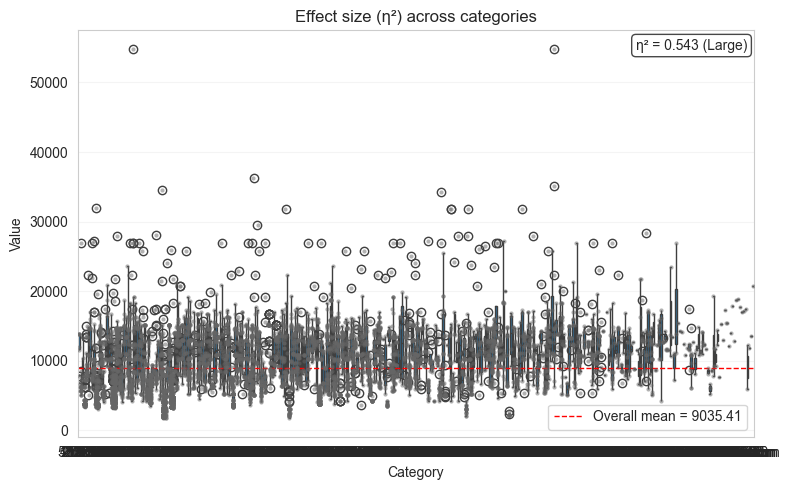

('Large',
 0.5429271130747538,
 <Axes: title={'center': 'Effect size (η²) across categories'}, xlabel='Category', ylabel='Value'>)

In [114]:
plot_eta(categories=non_null_planes['Duration'], values=non_null_planes['Price'])